In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [2]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
    
from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


# 1 Data Loading

In [3]:
raw_analysis = pd.read_csv('./analysisData.csv')
raw_scoring = pd.read_csv('./scoringData.csv')

In [4]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_train = raw_analysis.copy()
df_test = raw_scoring.copy()
df_all = concat_df(df_train, df_test)

In [5]:
print('The shape of training set: {}'.format(df_train.shape))
print('The shape of test set: {}'.format(df_test.shape))
print('The shape of ALL set: {}'.format(df_all.shape))

The shape of training set: (36839, 91)
The shape of test set: (9210, 90)
The shape of ALL set: (46049, 91)


In [6]:
print('The dependent variable we need to predict is: {}'.format(set(list(df_train.columns))-set(list(df_test.columns))))

The dependent variable we need to predict is: {'price'}


In [8]:
pd.set_option('display.max_columns', 100)
df_all.sample(3)

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_updated,cancellation_policy,city,cleaning_fee,country,country_code,description,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_total_listings_count,host_verifications,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,license,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,price,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type,security_deposit,smart_location,space,square_feet,state,street,summary,transit,weekly_price,zipcode
8273,All of the apartment except the other private ...,2,"TV,Wifi, Air conditioning ,Kitchen,Breakfast,H...",22,186,33,33,1.5,Real Bed,1,1.0,1,0,1,0,yesterday,moderate,Brooklyn,25.0,United States,US,"The apartment is cozy, air-conditioned and he...",10,2019-05-14,1,t,NaN,NaN,t,f,f,1.0,US,Sylvia,Bushwick,100%,within an hour,2019-05-10,1.0,"['email', 'phone', 'offline_government_id', 's...",Quiet hours: every Wednesday from 7:30pm to 8:...,33021395,t,The apartment is a three bedroom apartment and...,f,t,NaN,2019-05-14,NaN,New York,31,20,31,31.0,31,3,3,4.3,NaN,<Great room in creative Bushwick>,As previously mentioned the area is a very cre...,Bushwick,Bushwick,Brooklyn,NaN,1,1,70.0,Apartment,f,f,f,10,10,10,10,10,100,10,1.00,Private room,0.0,"Brooklyn, NY",Perfect place for busy people coming to the ci...,NaN,NY,"Brooklyn, NY, United States","The apartment is cozy, air-conditioned and he...","M train, Knickerbocker station is a block awa...",NaN,11237
33085,"Frontyard, livingroom, kitchen, and bathroo...",3,"Internet,Wifi, Air conditioning ,Kitchen,Break...",30,365,60,90,1.0,Real Bed,1,2.0,2,0,2,0,today,strict_14_with_grace_period,Brooklyn,25.0,United States,US,Why stay in a hotel when you can enjoy your st...,20,2013-03-25,1,t,"I am easygoing, and enjoy to host people. A pr...",NaN,t,t,f,2.0,"New York, New York, United States",Natasha,Lefferts Garden,NaN,NaN,2011-10-31,2.0,"['email', 'phone', 'reviews', 'kba']",Lock the outside doors when you leave and when...,1270790,f,As much as guests want. I may or may not be p...,f,t,NaN,2018-11-27,NaN,New York,365,5,365,365.0,365,5,5,5.0,NaN,<Large bedroom/Heart of Brooklyn>,"I love that my neighborhood is diverse, fun, ...",Lefferts Garden,Prospect-Lefferts Gardens,Brooklyn,NaN,108,21,49.0,Bed and breakfast,t,t,f,8,9,8,9,9,82,8,1.53,Private room,NaN,"Brooklyn, NY",Why stay in a hotel when you can enjoy your st...,NaN,NY,"Brooklyn, NY, United States",NaN,Public transportation are about 5 minutes away...,NaN,11225
20929,NaN,2,"Internet,Wifi, Air conditioning ,Kitchen, Paid...",29,89,59,89,1.0,Real Bed,1,1.0,1,0,1,0,20 months ago,strict_14_with_grace_period,Brooklyn,60.0,United States,US,My place is close to Pratt Institute's pastora...,0,2016-05-30,1,t,NaN,NaN,t,f,f,2.0,"San Francisco, California, United States",Deshawn,Clinton Hill,NaN,NaN,2016-05-17,2.0,"['email', 'phone', 'reviews', 'offline_governm...",NaN,9730695,f,Available to offer help through-out your stay,f,t,NaN,2017-05-29,N

In [8]:
df_train = df_train.replace(['t','f'],[1,0])
df_test = df_test.replace(['t','f'],[1,0])
df_all = df_all.replace(['t','f'],[1,0])


### <pre>1.1  X, y splitting </pre>

In [9]:
X_train = df_train.loc[:, df_train.columns!='price']
y_train = df_train.price
print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of y_train: {}'.format(y_train.shape))
X_test = df_test

The shape of X_train: (36839, 90)
The shape of y_train: (36839,)


In [10]:
X_all = concat_df(X_train, X_test)
print('The shape of X_all: {}'.format(X_all.shape))

The shape of X_all: (46049, 90)


In [11]:
#pd.concat([X_all[0:36839],X_train]).drop_duplicates(keep=False) # X_all[0:36839] is the same as X_train

## <pre>First deal with X_all.<br>Then split X_all -> X_train + X_test</pre>
### <pre >1.2 Feature Selection</pre>


In [12]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46049 entries, 0 to 46048
Data columns (total 90 columns):
access                                          28571 non-null object
accommodates                                    46049 non-null int64
amenities                                       46049 non-null object
availability_30                                 46049 non-null int64
availability_365                                46049 non-null int64
availability_60                                 46049 non-null int64
availability_90                                 46049 non-null int64
bathrooms                                       46049 non-null float64
bed_type                                        46049 non-null object
bedrooms                                        46049 non-null int64
beds                                            46031 non-null float64
calculated_host_listings_count                  46049 non-null int64
calculated_host_listings_count_entire_homes     46049 no

In [13]:
X_all.iloc[:,0:20].sample(3)
## useful now: 'accommodates','bathrooms','bedrooms','beds','cleaning_fee'

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,beds,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,calendar_updated,cancellation_policy,city,cleaning_fee,country
35968,NaN,3,"Internet,Wifi, Air conditioning ,Kitchen,Eleva...",0,0,0,0,1.0,Real Bed,1,1.0,1,1,0,0,50 months ago,strict_14_with_grace_period,Brooklyn,100.0,United States
27067,NaN,2,"Cable TV ,Wifi, Air conditioning ,Kitchen,Hea...",13,178,13,13,1.0,Real Bed,1,1.0,1,1,0,0,20 months ago,strict_14_with_grace_period,Brooklyn,60.0,United States
14683,Full access to the entire space with the excep...,3,"TV, Cable TV ,Internet,Wifi, Air conditioning ...",0,0,0,0,1.0,Real Bed,1,1.0,1,1,0,0,13 months ago,flexible,Brooklyn,40.0,United States


In [14]:
X_all.iloc[:,20:40].sample(3)
## extra_people, guests_included, has_availability

,country_code,description,extra_people,first_review,guests_included,has_availability,host_about,host_acceptance_rate,host_has_profile_pic,host_identity_verified,host_is_superhost,host_listings_count,host_location,host_name,host_neighbourhood,host_response_rate,host_response_time,host_since,host_total_listings_count,host_verifications
23362,US,Stay at a true NY apartment for a real NY expe...,30,2015-10-09,2,1,"Hi, I'm Jessica! I'm originally from LA and wo...",NaN,1.0,1.0,1.0,3.0,"New York, New York, United States",Jessica,Lower East Side,95%,within a few hours,2014-12-01,3.0,"['email', 'phone', 'reviews', 'jumio', 'govern..."
9136,US,Huge private master bedroom with PRIVATE entra...,0,2018-06-12,1,1,NaN,NaN,1.0,0.0,0.0,1.0,"Queens, New York, United States",Shah,Maspeth,50%,within a day,2016-09-28,1.0,"['email', 'phone', 'offline_government_id', 's..."
41951,US,"Offers two things, convenience & comfort! Sit...",20,2017-12-03,3,1,"Love plants, love colors, love shapes, love si...",NaN,1.0,0.0,0.0,3.0,"Brooklyn, New York, United States",Jae,Williamsburg,100%,within an hour,2017-01-17,3.0,"['email', 'phone', 'reviews', 'jumio', 'offlin..."


In [15]:
X_all.host_response_time.value_counts()

within an hour        19011
within a few hours     5805
within a day           3891
a few days or more      737
Name: host_response_time, dtype: int64

In [16]:
X_all.iloc[:,40:60].sample(3)
## 

,house_rules,id,instant_bookable,interaction,is_business_travel_ready,is_location_exact,jurisdiction_names,last_review,license,market,maximum_maximum_nights,maximum_minimum_nights,maximum_nights,maximum_nights_avg_ntm,minimum_maximum_nights,minimum_minimum_nights,minimum_nights,minimum_nights_avg_ntm,monthly_price,name
33559,We do not permit smoking in the unit. We do a...,2548864,0,We live in another apartment within the buildi...,0,1,NaN,2018-12-16,NaN,New York,30,1,30,30.0,30,1,1,1.0,NaN,<Bedford Stuyvesant Townhouse>
6482,". Wi-Fi: MySpecturmWifia8-2G, 5G / PW: square...",27725280,0,Airbnb & text,0,1,NaN,2018-12-27,NaN,New York,1125,1,1125,1125.0,1125,1,1,1.0,NaN,<Private Room 3A in 4BR/2BA APT in Hell's Kitc...
29042,NaN,15595687,1,I'm available by call or text for whatever gue...,0,0,NaN,2017-11-12,NaN,New York,3,1,3,3.0,3,1,1,1.0,NaN,<Spacious room in prime Upper West Side>


In [17]:
df_all.market.value_counts()

New York                       45916
Other (Domestic)                  19
San Francisco                      1
Adirondacks                        1
Lagos, NG                          1
South Bay, CA                      1
Paris                              1
Catskills and Hudson Valley        1
D.C.                               1
Cuba                               1
Jamaica South Coast                1
Agra                               1
London                             1
Atlanta                            1
Name: market, dtype: int64

In [18]:
df_all[X_all.is_business_travel_ready==1].price.mean()

nan

In [19]:
df_all[X_all.is_business_travel_ready==0].price.mean()

136.93230000814356

In [20]:
X_all.iloc[:,60:80].sample(3)
## review_scores_value, reviews_per_month, room_type,neighbourhood
#X_all.neighbourhood_group_cleansed()

,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,notes,number_of_reviews,number_of_reviews_ltm,property_type,require_guest_phone_verification,require_guest_profile_picture,requires_license,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,reviews_per_month,room_type
32926,I like the area because its live and everythin...,Hell's Kitchen,Hell's Kitchen,Manhattan,The radiator noise and sink is fixed,39,30,Apartment,0,0,0,9,10,8,10,10,87,9,2.53,Entire home/apt
45188,"Quiet residential street, with plenty of busi...",Harlem,East Harlem,Manhattan,Linen - I change all the linen every time a ne...,52,24,Apartment,1,1,0,10,10,9,10,9,95,9,1.94,Private room
25425,NaN,Crown Heights,Crown Heights,Brooklyn,NaN,39,3,House,0,0,0,10,10,9,10,8,93,9,1.22,Entire home/apt


In [23]:
X_all.neighbourhood_group_cleansed.value_counts(dropna=False)

Manhattan        20429
Brooklyn         18830
Queens            5439
Bronx             1010
Staten Island      341
Name: neighbourhood_group_cleansed, dtype: int64

In [22]:
X_all.iloc[:,80:91].sample(3)
## zipcode

,security_deposit,smart_location,space,square_feet,state,street,summary,transit,weekly_price,zipcode
25310,NaN,"Jackson Heights, NY",Quite and peaceful neighborhood.,NaN,NY,"Jackson Heights, NY, United States",Private room in Jackson Heights Historical Dis...,This property is 5 mins to the MTA bus located...,350.0,11370
6200,500.0,"Bronx, NY","Book new this clutter free, beautifully renov...",NaN,NY,"Bronx, NY, United States",This is just what you’ve been looking for. Th...,The 2 or 5 trains and plenty of buses for easy...,NaN,10467
10215,NaN,"New York, NY",NaN,NaN,NY,"New York, NY, United States",Large bright bedroom in the East Village conve...,NaN,NaN,10009


In [23]:
X_test.square_feet.value_counts(dropna=False)

NaN       9112
500.0       10
1200.0       9
0.0          7
700.0        6
1000.0       6
600.0        5
750.0        4
725.0        3
550.0        3
1500.0       3
800.0        3
2000.0       2
140.0        2
100.0        2
1800.0       2
450.0        2
900.0        2
780.0        2
850.0        2
300.0        2
1.0          2
650.0        2
950.0        2
250.0        1
210.0        1
12.0         1
320.0        1
870.0        1
1700.0       1
350.0        1
225.0        1
150.0        1
3700.0       1
400.0        1
130.0        1
1300.0       1
520.0        1
1100.0       1
Name: square_feet, dtype: int64

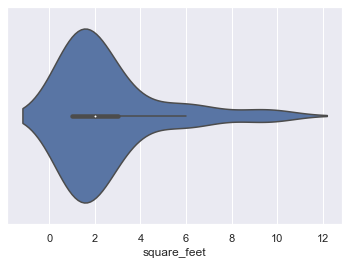

In [24]:

sns.violinplot(X_test.square_feet.value_counts())

within an hour        19011
NaN                   16605
within a few hours     5805
within a day           3891
a few days or more      737
Name: host_response_time, dtype: int64
host_response_time
a few days or more    132.931148
within a day          142.899135
within a few hours    145.612791
within an hour        138.169570
Name: price, dtype: float64


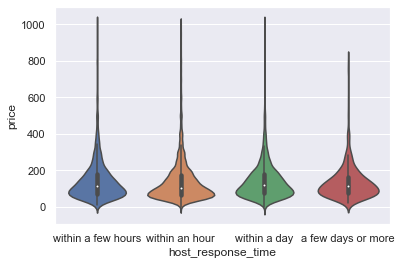

In [25]:

sns.violinplot(x="host_response_time", y="price", data=df_train)
#sns.barplot(x='host_total_listings_count',y='price',data=df_train)
print(X_all.host_response_time.value_counts(dropna=False))
print(df_train.groupby('host_response_time')["price"].mean())

In [26]:
X_all.zipcode.loc[X_all.zipcode.notnull()]

0        11101
1        10305
2        11205
3        10013
4        11233
5        10023
6        10036
7        10024
8        10023
9        10014
10       10039
11       11221
12       10024
13       10304
14       10029
15       11222
16       11221
17       11221
18       11211
19       11225
20       11229
21       10044
22       11206
23       11225
24       10075
25       11211
26       11221
27       11105
28       11203
29       10011
         ...  
46019    11216
46020    10456
46021    11211
46022    10010
46023    10012
46024    11216
46025    11372
46026    10036
46027    11221
46028    11692
46029    10466
46030    11215
46031    11222
46032    11237
46033    10013
46034    11369
46035    11221
46036    11233
46037    11213
46038    11106
46039    11368
46040    11229
46041    10033
46042    10029
46043    10019
46044    11221
46045    11421
46046    11224
46047    11237
46048    10002
Name: zipcode, Length: 45473, dtype: object

In [27]:
# for simplicity, straightforward select necessary columns
columns_keep = [
                'amenities','accommodates','bathrooms','bedrooms','beds','bed_type',
                'cancellation_policy','cleaning_fee','extra_people','host_response_time',
                'host_has_profile_pic','guests_included',
                'review_scores_value', 'reviews_per_month', 'room_type','property_type',
                'security_deposit','zipcode'
               ]

X_all = df_all.loc[:, columns_keep]
#'property_type' too many types
# review_scores_values need to mapping
#'security_deposit' needs to mapping
#'bathrooms' delete outlier and mapping
#
#X_all = X_all.loc[:,columns_keep]

In [28]:
#X_all.neighbourhood_cleansed.value_counts()[1:20]

### <pre >1.3 Deal with Missing Value</pre>

In [29]:
X_all.sample(5)

,amenities,accommodates,bathrooms,bedrooms,beds,bed_type,cancellation_policy,cleaning_fee,extra_people,host_response_time,host_has_profile_pic,guests_included,review_scores_value,reviews_per_month,room_type,property_type,security_deposit,zipcode
27880,"TV,Wifi, Air conditioning ,Kitchen, Smoking al...",1,1.0,1,1.0,Real Bed,flexible,25.0,18,within a day,1.0,1,10,0.73,Private room,Apartment,0.0,11237
3984,"TV,Internet,Wifi, Air conditioning ,Kitchen, S...",1,1.5,1,1.0,Real Bed,flexible,25.0,10,NaN,1.0,1,9,0.22,Private room,Loft,NaN,11206
39915,"TV,Internet,Wifi, Air conditioning ,Kitchen,El...",2,1.0,0,1.0,Real Bed,strict_14_with_grace_period,NaN,50,within an hour,1.0,1,10,0.20,Entire home/apt,Apartment,100.0,10019
19136,"Wifi,Kitchen, Pets allowed , Free street parki...",2,1.0,1,1.0,Real Bed,flexible,35.0,20,within an hour,1.0,1,10,1.00,Private room,Apartment,0.0,10455
19905,"Internet,Wifi, Air conditioning ,Kitchen,Eleva...",2,1.0,1,1.0,Real Bed,moderate,15.0,10,NaN,1.0,1,10,0.37,Private room,Apartment,100.0,10021


In [30]:
def int_transform(x):
    try: 
        if type(x)==str:
            value = int(x[0:5])
        else:
            value = int(x)
    except:
        value = 0
    return value

X_all.zipcode = X_all.zipcode.apply(int_transform)

In [31]:
(X_all.zipcode==0).value_counts()

False    45472
True       577
Name: zipcode, dtype: int64

In [32]:
X_all.beds = X_all.beds.fillna(X_all.beds.median())
X_all.reviews_per_month = X_all.reviews_per_month.fillna(X_all.reviews_per_month.median())
X_all['cleaning_fee_missing'] = X_all.cleaning_fee.isna()
X_all.cleaning_fee = X_all.cleaning_fee.fillna(X_all.cleaning_fee.median())
X_all.host_has_profile_pic = X_all.host_has_profile_pic.fillna(False)
X_all['security_deposit_missing']  = X_all.security_deposit.isna()
X_all.security_deposit = X_all.groupby(['beds','room_type'])['security_deposit'].apply(lambda x:x.fillna(x.median()))

In [33]:
X_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46049 entries, 0 to 46048
Data columns (total 20 columns):
amenities                   46049 non-null object
accommodates                46049 non-null int64
bathrooms                   46049 non-null float64
bedrooms                    46049 non-null int64
beds                        46049 non-null float64
bed_type                    46049 non-null object
cancellation_policy         46049 non-null object
cleaning_fee                46049 non-null float64
extra_people                46049 non-null int64
host_response_time          29444 non-null object
host_has_profile_pic        46049 non-null object
guests_included             46049 non-null int64
review_scores_value         46049 non-null int64
reviews_per_month           46049 non-null float64
room_type                   46049 non-null object
property_type               46049 non-null object
security_deposit            46045 non-null float64
zipcode                     46049 non-nul

In [34]:
X_all.security_deposit = X_all.security_deposit.fillna(X_all.security_deposit.median())

In [35]:
continuous_features = ['cleaning_fee','reviews_per_month','security_deposit']
num_features = X_all.dtypes[X_all.dtypes!='object'].index
skewness_features = X_all.loc[:,num_features].skew().sort_values(ascending=False)
skewness_features

extra_people                4.200536
bathrooms                   4.133438
guests_included             3.449794
beds                        3.032778
accommodates                2.298120
bedrooms                    2.142594
cleaning_fee                1.988105
reviews_per_month           1.975462
cleaning_fee_missing        1.818144
security_deposit            1.426398
security_deposit_missing    0.627506
zipcode                    -1.111343
review_scores_value        -2.961109
dtype: float64

In [37]:
from scipy.stats import boxcox
for i in skewness_features.index:
    if abs(skewness_features[i]) > 1.9:
        df_tmp = X_all[i].apply(lambda x:x+0.00001)
        try:
            X_all[i],lmbda = boxcox(df_tmp,lmbda=None)
        except:
            print(i)

In [38]:
num_features = X_all.dtypes[X_all.dtypes!='object'].index
skewness_features = X_all.loc[:,num_features].skew().sort_values(ascending=False)
skewness_features

cleaning_fee_missing        1.818144
security_deposit            1.426398
bathrooms                   1.216900
guests_included             0.805711
security_deposit_missing    0.627506
beds                        0.306492
accommodates                0.008074
reviews_per_month          -0.071370
extra_people               -0.130002
cleaning_fee               -0.443801
review_scores_value        -0.485133
bedrooms                   -0.758570
zipcode                    -1.111343
dtype: float64

In [41]:
for i in range(10):#len(X_all)):
    result = [x.strip() for x in X_all.amenities[i].split(',')]
    result[-1] = result[-1][:-1].strip()
    print('{} ----> {}'.format(result,df_all.price[i]))
#     for s in result:
#         try:
#             X_all[s].iloc[i] = 1
#         except:
#             X_all[s] = 0
#             X_all[s].iloc[i] = 1

['Wifi', 'Air conditioning', 'Kitchen', 'Elevator', 'Washer', 'Dryer', 'Smoke detector', 'Carbon monoxide detector', 'Essentials', 'Hair dryer', 'Laptop friendly workspace', 'Private entrance'] ----> 65.0
['TV', 'Wifi', 'Free street parking', 'Smoke detector', 'Carbon monoxide detector', 'Essentials', 'Shampoo', 'Lock on bedroom door', 'Hair dryer', 'translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50', 'Private entrance', 'Hot water', 'Host greets you'] ----> 70.0
['Wifi', 'Air conditioning', 'Kitchen', 'Heating', 'Smoke detector', 'Essentials', 'Lock on bedroom door', 'Laptop friendly workspace'] ----> 47.0
['Wifi', 'Air conditioning', 'Heating', 'Smoke detector', 'Carbon monoxide detector', 'First aid kit', 'Fire extinguisher', 'Essentials', 'Shampoo', 'Hangers', 'Hair dryer', 'Iron', 'Laptop friendly workspace', 'Hot water', 'Bed linens', 'Extra pillows and blankets', 'Microwave', 'Coffee maker', 'Refrigerator', 'Dishes and silverware', 'Cooking

['TV',
 'Wifi',
 'Air conditioning',
 'Kitchen',
 'Elevator',
 'Buzzer/wireless intercom',
 'Heating',
 'Washer',
 'Dryer',
 'Essentials',
 'Laptop friendly workspace']

In [81]:
X_all.amenities[213]

'TV,Wifi, Air conditioning ,Kitchen,Elevator, Buzzer/wireless intercom ,Heating,Washer,Dryer,Essentials, Laptop friendly workspace .'

### <pre >1.4 Deal with Categorical Features</pre>

In [ ]:
df_all.sample(5)

In [ ]:
X_all.info()

In [ ]:
X_all.shape#.value_counts()

In [ ]:
#X_all.zipcode.value_counts()

In [ ]:
X_all_room_type = pd.get_dummies(X_all.room_type)
X_all = pd.concat([X_all, X_all_room_type], axis=1)
X_all_bed_type = pd.get_dummies(X_all.bed_type)
X_all = pd.concat([X_all,X_all_bed_type],axis=1)
X_all_property_type = pd.get_dummies(X_all.property_type)
X_all = pd.concat([X_all,X_all_property_type],axis=1)
X_all_host_has_profile_pic = pd.get_dummies(X_all.host_has_profile_pic)
X_all = pd.concat([X_all,X_all_host_has_profile_pic],axis=1)
X_all_zip_code = pd.get_dummies(X_all.zipcode)
X_all = pd.concat([X_all,X_all_zip_code],axis=1)
X_all.head()

In [ ]:
X_all.head()

In [ ]:
X_all = X_all.drop(['room_type','bed_type','property_type','host_has_profile_pic','zipcode'],axis=1)

In [ ]:
# nbc = pd.DataFrame(df_all.groupby(['neighbourhood_cleansed'])['price'].mean())
# nbc.price = nbc.price.fillna(nbc.price.median())
# nbc = nbc.sort_values(by='price',ascending=False)

# sns.distplot(nbc.price)


In [ ]:
# nbc_cut = pd.cut(nbc.price, bins = [0,50,70,90,110,130,150,170,190,210,230,250,1000],labels=['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11','p12'])
# X_all.neighbourhood_cleansed = X_all.neighbourhood_cleansed.map(nbc_cut)

In [ ]:
# X_all_nbc = pd.get_dummies(X_all.neighbourhood_cleansed)
# X_all = pd.concat([X_all,X_all_nbc],axis=1)


In [ ]:
# X_all = X_all.drop('neighbourhood_cleansed',axis=1)

In [ ]:
X_all.info()

#### Dealing with skewness

In [80]:
skewed_feats = X_all.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(30)


Skew in numerical features: 



,Skew
1m,214.583317
Lighthouse,214.583317
Houseboat,214.583317
11001,214.583317
Pension (South Korea),214.583317
Timeshare,214.583317
11413-3220,214.583317
10129,214.583317
Dome house,214.583317
Cave,214.583317


#### PCA

In [38]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_all_scaled = pd.DataFrame(ss.fit_transform(X_all),columns=X_all.columns)

In [39]:
X_all_scaled.sample(3)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,extra_people,guests_included,review_scores_value,reviews_per_month,security_deposit,cleaning_fee_missing,security_deposit_missing,Entire home/apt,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed,Aparthotel,Apartment,Bed and breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Casa particular (Cuba),Castle,Cave,Condominium,Cottage,Dome house,Earth house,Farm stay,Guest suite,Guesthouse,Hostel,Hotel,House,Houseboat,Lighthouse,Loft,Nature lodge,Other,Pension (South Korea),Resort,Serviced apartment,Tent,Timeshare,Tiny house,Townhouse,Villa,0.0,1.0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12
11582,-0.503528,-0.335701,-0.251145,-0.525198,-0.224468,-0.661320,-0.494296,0.667063,-0.691111,0.256023,2.260470,1.361805,0.941901,-0.897372,-0.156945,-0.057167,-0.037597,-0.08125,-0.076223,0.131521,-0.013981,0.515267,-0.045945,-0.013981,-0.046417,-0.027183,-0.00659,-0.01233,-0.008072,-0.00466,-0.00466,-0.172523,-0.010421,-0.00466,-0.008072,-0.00466,-0.084047,-0.033623,-0.042236,-0.037597,-0.296494,-0.00466,-0.00466,-0.183053,-0.00466,-0.047116,-0.00466,-0.034264,-0.103921,-0.00932,-0.00466,-0.020317,-0.19083,-0.024666,-0.043003,0.043003,-0.025955,-0.138117,-0.491543,-0.450955,-0.353104,2.408926,-0.275702,-0.430539,-0.199817,-0.159684,-0.258244,-0.080022
5379,0.020838,-0.335701,-0.251145,-0.525198,-0.009258,1.397735,0.347674,0.667063,1.693986,0.903403,-0.442386,-0.734320,0.941901,-0.897372,-0.156945,-0.057167,-0.037597,-0.08125,-0.076223,0.131521,-0.013981,0.515267,-0.045945,-0.013981,-0.046417,-0.027183,-0.00659,-0.01233,-0.008072,-0.00466,-0.00466,-0.172523,-0.010421,-0.00466,-0.008072,-0.00466,-0.084047,-0.033623,-0.042236,-0.037597,-0.296494,-0.00466,-0.00466,-0.183053,-0.00466,-0.047116,-0.00466,-0.034264,-0.103921,-0.00932,-0.00466,-0.020317,-0.19083,-0.024666,-0.043003,0.043003,-0.025955,-0.138117,-0.491543,-0.450955,-0.353104,-0.415123,-0.275702,2.322672,-0.199817,-0.159684,-0.258244,-0.080022
26943,-0.503528,-0.335701,-0.251145,-0.525198,-0.224468,-0.661320,-0.494296,0.667063,-0.673042,-1.038736,-0.442386,-0.734320,-1.061683,1.114365,-0.156945,-0.057167,-0.037597,-0.08125,-0.076223,0.131521,-0.013981,0.515267,-0.045945,-0.013981,-0.046417,-0.027183,-0.00659,-0.01233,-0.008072,-0.00466,-0.00466,-0.172523,-0.010421,-0.00466,-0.008072,-0.00466,-0.084047,-0.033623,-0.042236,-0.037597,-0.296494,-0.00466,-0.00466,-0.183053,-0.00466,-0.047116,-0.00466,-0.034264,-0.103921,-0.00932,-0.00466,-0.020317,-0.19083,-0.024666,-0.043003,0.043003,-0.025955,-0.138117,2.034410,-0.450955,-0.353104,-0.415123,-0.275702,-0.430539,-0.199817,-0.159684,-0.258244,-0.080022


In [40]:
from sklearn.decomposition import PCA


pca = PCA(n_components = 63).fit(X_all_scaled)
X_pca = pca.transform(X_all_scaled)

In [41]:
pca.explained_variance_ratio_

array([0.06317086, 0.03502459, 0.02976755, 0.02938213, 0.02405026,
       0.02264198, 0.01943313, 0.01826349, 0.01823286, 0.0173807 ,
       0.01697096, 0.01690802, 0.01659742, 0.01604338, 0.01581083,
       0.01573858, 0.01559419, 0.01533141, 0.01513104, 0.0150276 ,
       0.0149615 , 0.01490086, 0.01479824, 0.0147897 , 0.01476097,
       0.01472958, 0.01472272, 0.0147169 , 0.01471361, 0.01471242,
       0.0147094 , 0.01470878, 0.01470802, 0.01470734, 0.01470692,
       0.01470581, 0.01470095, 0.01469056, 0.01468411, 0.0146645 ,
       0.01463948, 0.01462986, 0.01457323, 0.01449999, 0.01448544,
       0.01432526, 0.01421794, 0.01415798, 0.01402534, 0.01389462,
       0.0137526 , 0.01340363, 0.01309968, 0.01293396, 0.01264461,
       0.01134813, 0.01039791, 0.00920199, 0.00738023, 0.00713979,
       0.00666841, 0.00451302, 0.00277306])

In [42]:
X_pca.shape[1]

63

In [43]:
X_all_pca = pd.DataFrame(data=X_pca, 
                          index=range(0,len(X_all)),
                          columns=["PCA_{}".format(i) for i in range(X_pca.shape[1])]
                         )

In [44]:
X_all_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,PCA_21,PCA_22,PCA_23,PCA_24,PCA_25,PCA_26,PCA_27,PCA_28,PCA_29,PCA_30,PCA_31,PCA_32,PCA_33,PCA_34,PCA_35,PCA_36,PCA_37,PCA_38,PCA_39,PCA_40,PCA_41,PCA_42,PCA_43,PCA_44,PCA_45,PCA_46,PCA_47,PCA_48,PCA_49,PCA_50,PCA_51,PCA_52,PCA_53,PCA_54,PCA_55,PCA_56,PCA_57,PCA_58,PCA_59,PCA_60,PCA_61,PCA_62
0,-1.470772,1.813289,-0.183759,0.126967,1.319378,-1.249959,-0.260699,-1.558887,2.160659,-0.657760,1.720535,-1.466530,0.613657,1.968454,-0.310202,0.406135,-0.062451,-1.657575,-3.238799,2.079904,-1.965234,3.007412,-1.398879,0.950388,-0.927253,1.505223,-0.267002,-1.063869,0.888348,0.114128,0.387859,0.121072,0.035056,-0.299066,0.411427,-0.303539,-0.545532,-1.098122,-0.367242,-0.944597,1.619746,-1.662555,2.904164,0.665695,-0.913508,0.804765,-1.787181,3.703593,0.217167,-0.644909,-0.343891,1.605326,1.630771,-0.768785,0.537729,-2.444340,0.943168,-0.297528,-0.151616,-0.369413,0.199941,0.267327,0.072414
1,-0.828420,3.244599,-0.042398,0.071534,-0.029565,-0.207784,0.352575,-1.197167,-1.055117,0.371486,-1.418195,0.082689,-0.508385,0.238014,-0.738617,-1.640697,0.680616,0.591996,-0.263576,0.305457,0.035583,-0.179000,0.264315,0.153207,0.273611,-0.178558,0.066816,-0.072884,0.023760,-0.011754,0.060738,-0.007831,0.030590,-0.020600,0.012028,-0.002203,-0.088658,-0.004762,0.014991,-0.068470,0.013296,0.119862,0.398978,0.383278,-0.129357,-0.348966,0.796444,0.672931,-0.924540,0.050829,0.751040,0.474049,0.480749,-0.344156,-0.249782,0.411601,-0.638179,1.350503,-0.402764,-0.178538,0.939374,0.500466,0.387015
2,-1.926307,-0.012102,-0.395154,0.263571,1.393245,2.205380,0.797466,-1.282150,-0.975472,0.414687,-0.579117,0.278391,0.276476,0.298569,-0.034372,-0.233848,-0.244158,0.605570,0.237011,0.146950,-0.057886,0.072595,0.149858,0.109787,-0.040701,-0.041905,-0.013168,0.045398,-0.000282,-0.006129,-0.000726,0.000915,-0.019661,0.001268,0.000220,0.002458,0.057427,0.041500,-0.089385,-0.114580,-0.132650,0.203413,0.163131,0.275571,-0.086735,-0.290970,0.485419,0.032940,-0.158081,-0.262299,-0.309375,0.070129,-0.516480,0.495353,0.114749,-0.349319,0.224559,0.303497,-0.090481,0.679637,-0.093121,-0.229397,-0.595317
3,-1.461957,0.789830,-0.457785,0.056531,-2.457193,0.040989,-1.006236,-0.161720,-0.248282,-0.880500,0.811138,-0.180740,-0.529273,-2.095343,2.199873,0.053636,-1.502632,-1.012544,0.286459,-0.372846,-0.271456,-0.498831,-0.259144,0.582191,0.084354,0.123010,-0.078439,-0.076160,0.021632,0.027918,0.059190,0.027631,-0.010245,-0.050769,0.061239,-0.061918,-0.068833,-0.112701,0.133141,-0.141828,0.125461,-0.117926,-0.063309,0.488147,0.002333,1.708451,-0.983432,1.628282,0.267769,-0.398217,0.102371,1.550251,-1.318460,1.710309,-0.487634,1.779719,1.605059,-0.062276,-0.139588,-0.071671,0.462304,0.247348,-0.353765
4,-1.862211,0.650559,-0.343811,0.036567,-1.652184,0.507428,0.661572,-1.543329,-0.718702,0.429838,-0.586188,0.561824,0.043133,0.162332,-0.003727,-0.225223,-0.290077,0.119430,-0.067614,0.128886,-0.317420,-0.245114,0.109293,0.252045,0.000178,0.063953,-0.009270,-0.001088,-0.013316,0.003108,0.006945,0.000645,-0.012935,-0.004818,0.004238,-0.003632,0.030008,0.023951,0.051495,-0.100617,0.170199,0.169868,0.201498,0.346691,-0.022337,-0.102225,0.321915,0.733756,0.055740,0.303306,-0.045790,0.284305,-0.601524,0.326530,0.007146,-0.199615,0.255661,-0.000649,-0.006053,0.173631,0.264752,0.056703,-0.103767


### split X_all

In [45]:
X_train, X_test = X_all.iloc[0:36839], X_all.iloc[36839:]
print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))

from sklearn.model_selection import train_test_split
X, X_dev, y, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=88)

print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))


print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))
print('X_dev: {}'.format(X_dev.shape))
print('y_dev: {}'.format(y_dev.shape))

X_train: (36839, 68)
X_test: (9210, 68)
X_train: (36839, 68)
y_train: (36839,)
X_test: (9210, 68)
X: (29471, 68)
y: (29471,)
X_dev: (7368, 68)
y_dev: (7368,)


In [46]:
X_train_pca, X_test_pca = X_all_pca.iloc[0:36839], X_all_pca.iloc[36839:]
print('X_train: {}'.format(X_train_pca.shape))
print('X_test: {}'.format(X_test_pca.shape))


X_train: (36839, 63)
X_test: (9210, 63)


In [47]:
#X, y = X_train.sample(1000), y_train.sample(1000)

# 2 Model Training

In [48]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=25)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.2,0.5,0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e5, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e4, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))
                                        
# svr = make_pipeline(RobustScaler(),
#                       SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                  # max_depth=4,
                                   max_features='sqrt',
                                   #min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=3000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3000,
                                     #max_depth=3, 
                                     min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

randomforest = RandomForestRegressor(n_estimators= 2000,
                                     #max_depth= 5
                                    )

# stack
# stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
#                                             gbr, randomforest,lightgbm),
#                                 meta_regressor=gbr)
# score = cv_rmse(stack_gen)                       

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

# score = cv_rmse(svr)
# print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(randomforest)
print("randomforest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )


print('START Fit') 
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X,y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X,y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X,y)
# print(datetime.now(), 'svr')
# svr_model_full_data = svr.fit(X,y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X,y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X,y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X,y)
print(datetime.now(), 'randomforest')
rf_model_full_data = randomforest.fit(X,y)

TEST score on CV
Kernel Ridge score: 67.5511 (1.4343)
 2019-11-13 09:28:53.131590
Lasso score: 67.4964 (1.4558)
 2019-11-13 09:29:26.895422
ElasticNet score: 67.4924 (1.4462)
 2019-11-13 09:30:36.714111
Lightgbm score: 63.1108 (1.7156)
 2019-11-13 09:30:47.403846
GradientBoosting score: 61.6256 (1.7231)
 2019-11-13 09:32:48.063530
[09:32:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:34:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:35:51] 

In [49]:
All_models_list = [elastic_model_full_data,
                   lasso_model_full_data,
                   ridge_model_full_data,
                   #svr_model_full_data,
                   gbr_model_full_data,
                   xgb_model_full_data,
                   lgb_model_full_data,
                   rf_model_full_data
                  ]
#All_models_list
#X_t = X_train.sample()
from vecstack import stacking
S_train, S_test = stacking(All_models_list,                   
                           X,y, X_dev,   
                           regression=True, 
                           mode='oof_pred_bag', 
                           save_dir=None, 
                           metric= mean_squared_error, 
                           n_folds=4, 
                           stratified=True,
                           shuffle=True,  
                           random_state=0,    
                           verbose=2)

parameters = {'n_estimators':[300],
              'min_samples_leaf': [1,2],#list(range(1,)),
              'max_depth' : [2,3,4]#list(range(1,3))
             }
# n_estimators = [50]#,200,300]
# learning_rate = [0.001]#0.01,0.02,0.1,0.2]

# param = {'learning_rate': learning_rate,
#          'n_estimators' : n_estimators,
#         }

In [51]:
model_sec_level = GridSearchCV(estimator=RandomForestRegressor(bootstrap = True, max_features='sqrt'),
                           param_grid=parameters,
                           scoring = 'neg_mean_squared_error',
                           cv=5,
                           n_jobs = -1
                          )


model_sec_level = model_sec_level.fit(S_train, y)
print(model_sec_level.best_score_)
y_pred = model_sec_level.predict(S_test)
print('rmse: {}'.format(rmsle(y_dev,y_pred)))

-3751.7516809737263
rmse: 62.92664765387175


In [102]:
S_test_df = pd.DataFrame(S_test)

In [105]:
#S_test_df.iloc[:,6]

In [52]:
#y_pred = RandomForestClassifier(n_estimators=1000).fit(S_train,y).predict(S_test)
#y_pred = model_sec_level.best_estimator_.predict(S_test)

y_pred = (0.05*np.array(elastic_model_full_data.fit(X_train,y_train).predict(X_train)) 
         +0.05*np.array(lasso_model_full_data.fit(X_train,y_train).predict(X_train))
         +0.05*np.array(ridge_model_full_data.fit(X_train,y_train).predict(X_train))
         +0.3*np.array(gbr_model_full_data.fit(X_train,y_train).predict(X_train))
         +0.35*np.array(xgb_model_full_data.fit(X_train,y_train).predict(X_train))
         +0.1*np.array(lgb_model_full_data.fit(X_train,y_train).predict(X_train))
          
         +0.1*np.array(rf_model_full_data.fit(X_train,y_train).predict(X_train))
         )
# y_pred = (0.1*np.array(elastic_model_full_data.fit(X,y).predict(X_dev)) 
#          +0.1*np.array(lasso_model_full_data.fit(X,y).predict(X_dev))
#          +0.1*np.array(ridge_model_full_data.fit(X,y).predict(X_dev))
#          +0.3*np.array(gbr_model_full_data.fit(X,y).predict(X_dev))
#          +0.2*np.array(xgb_model_full_data.fit(X,y).predict(X_dev))
#          +0.2*np.array(lgb_model_full_data.fit(X,y).predict(X_dev))
#          )
                    #+0.05*rf_model_full_data.fit(X,y).predict(X_dev)

print('rmse: {}'.format(rmsle(y_train,y_pred)))


[11:02:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse: 55.275311962492495


In [ ]:
print('rmse: {}'.format(rmsle(y_train,y_pred)))

In [82]:
S_test.shape

(9210, 8)

In [62]:
stack_gen
#score = cv_rmse()
#print("score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

StackingCVRegressor(cv=5,
                    meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.7, gamma=0,
                                                importance_type='gain',
                                                learning_rate=0.01,
                                                max_delta_step=0, max_depth=4,
                                                min_child_weight=0,
                                                missing=None, n_estimators=200,
                                                n_jobs=1, nthread=-1,
                                                objective='reg:squarederror',
                                                random_state=0, reg_alpha=0.0...
                                

array([[6, 1.0, 2, ..., 1, 0, 0],
       [2, 1.0, 1, ..., 0, 0, 0],
       [15, 1.0, 3, ..., 0, 0, 0],
       ...,
       [4, 1.0, 0, ..., 0, 0, 0],
       [2, 1.0, 1, ..., 1, 0, 0],
       [6, 1.0, 3, ..., 0, 0, 0]], dtype=object)

In [46]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size=.20, random_state=15) # need to learn

In [ ]:
All_models = {} # {model1: model1_score, model2:model2_score}

In [ ]:
from sklearn.model_selection import cross_val_score  

#### 2.1 Linear

In [ ]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train,y_train)
LR_score = np.mean(cross_val_score(LR, X_train, y_train, cv=10, ))
print("The CV score is:\n{:0.4f}".format(LR_score))

#### 2.2 RandomForest

In [530]:
from sklearn.ensemble import RandomForestRegressor
n_estimators = [50]
#max_depth = [2,3,5,7,9,11,13,15,17]

parameters = {'n_estimators':n_estimators,
            #  'min_samples_leaf': min_samples_leaf,
            #  'max_depth':max_depth,
              }
RF = GridSearchCV(estimator=RandomForestRegressor(max_features='auto'),
                           param_grid=parameters,
                           cv=5,
                           n_jobs = -1,
                           scoring = 'neg_mean_squared_error'
                          )
#RF = RandomForestRegressor(n_estimators = 300, random_state = 0) 
RF.fit(X_train,y_train) 
#RF_score = np.mean(cross_val_score(RF, X_train, y_train, cv=5 ))
print("The best CV rmse is:\n{:0.4f}".format(np.sqrt(-RF.best_score_)))

The best CV rmse is:
63.9435


In [531]:
RF.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [143]:
from sklearn.ensemble import RandomForestRegressor
score = []
for i in range(5,61,5):
    n_estimators = [50]
    #max_depth = [15,17,23,30]

    parameters = {'n_estimators':n_estimators,
                #  'min_samples_leaf': min_samples_leaf,
                #  'max_depth':max_depth,
                  }
    RF = GridSearchCV(estimator=RandomForestRegressor(max_features='auto'),
                               param_grid=parameters,
                               cv=3,
                               n_jobs = -1,
                               scoring = 'neg_mean_squared_error'
                              )
    #RF = RandomForestRegressor(n_estimators = 300, random_state = 0) 
    RF.fit(X_train_pca,y_train) 
    score.append(np.sqrt(-RF.best_score_))
    #print("The best CV rmse for {} is:{:0.4f}".format(i,np.sqrt(-RF.best_score_)))

KeyboardInterrupt: 

In [554]:
RF.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [96]:
from xgboost import XGBRegressor
parameters = {'n_estimators':[50],
            #  'min_samples_leaf': min_samples_leaf,
            #  'max_depth':max_depth,
              }
XGB = GridSearchCV(estimator=XGBRegressor(max_features='auto'),
                           param_grid=parameters,
                           cv=3,
                           n_jobs = -1,
                           scoring = 'neg_mean_squared_error'
                          )
XGB.fit(X_train,y_train) 
#RF_score = np.mean(cross_val_score(RF, X_train, y_train, cv=5 ))
print("The best CV rmse is:\n{:0.4f}".format(np.sqrt(-XGB.best_score_)))

[21:29:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best CV rmse is:
69.1051


In [94]:
from xgboost import XGBRegressor
parameters = {'n_estimators':[500],
            #  'min_samples_leaf': min_samples_leaf,
            #  'max_depth':max_depth,
              }
XGB = GridSearchCV(estimator=XGBRegressor(max_features='auto'),
                           param_grid=parameters,
                           cv=3,
                           n_jobs = -1,
                           scoring = 'neg_mean_squared_error'
                          )
XGB.fit(X_train_pca,y_train) 
#RF_score = np.mean(cross_val_score(RF, X_train, y_train, cv=5 ))
print("The best CV rmse is:\n{:0.4f}".format(np.sqrt(-XGB.best_score_)))

[21:21:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The best CV rmse is:
62.8154


In [ ]:
result = RF.predict(X_test)
result_df = pd.DataFrame(columns=['id','price'])
result_df['id'] = df_test.id
result_df['price'] = result
result_df = result_df.astype(int)
result_df.to_csv('submissions.csv', index=False)
result_df

In [ ]:
df_test.id